In [1]:
'''
Way to load mat file in python
Using scipy library
'''

'\nWay to load mat file in python\nUsing scipy library\n'

In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import rbf_kernel
from tensorflow.keras import models, layers, optimizers, callbacks # type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA, PCA
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import warnings
warnings.filterwarnings("ignore")

In [3]:
umist = loadmat('umist_cropped.mat')
umist.keys()

dict_keys(['__header__', '__version__', '__globals__', 'facedat', 'dirnames'])

In [4]:
dataset = umist['facedat']

In [5]:
print(f'data.shape: {dataset.shape}')
print(f'data[0].shape: {dataset[0].shape}')
print(f'data[0][0].shape: {dataset[0][0].shape}')

data.shape: (1, 20)
data[0].shape: (20,)
data[0][0].shape: (112, 92, 38)


In [6]:
'''
First understand the shape of the dataset:
The dataset contains 1 x 20 which is a list of 20 sub-arrays
20 sub-arrays may be 20 different persons
Each image is 112x92 pixels
112 is the height of the image
92 is the width of the image

Shape of 1 person: 112 x 92 x n_images
'''

'\nFirst understand the shape of the dataset:\nThe dataset contains 1 x 20 which is a list of 20 sub-arrays\n20 sub-arrays may be 20 different persons\nEach image is 112x92 pixels\n112 is the height of the image\n92 is the width of the image\n\nShape of 1 person: 112 x 92 x n_images\n'

In [7]:
# Combine all the images of all the persons into a single list
data_lst = []

for i in range(20):
    person_imgs = dataset[0][i]
    for j in range(person_imgs.shape[2]):
        img = person_imgs[:, :, j]
        img_flat = img.flatten()
        data_lst.append(np.append(img_flat, i))

In [8]:
# Convert into DataFrame
df_columns = [f'pixel_{i}' for i in range(112*92)] + ['label']
df = pd.DataFrame(data_lst, columns=df_columns)
df.head(5)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,pixel_39,...,pixel_10265,pixel_10266,pixel_10267,pixel_10268,pixel_10269,pixel_10270,pixel_10271,pixel_10272,pixel_10273,pixel_10274,pixel_10275,pixel_10276,pixel_10277,pixel_10278,pixel_10279,pixel_10280,pixel_10281,pixel_10282,pixel_10283,pixel_10284,pixel_10285,pixel_10286,pixel_10287,pixel_10288,pixel_10289,pixel_10290,pixel_10291,pixel_10292,pixel_10293,pixel_10294,pixel_10295,pixel_10296,pixel_10297,pixel_10298,pixel_10299,pixel_10300,pixel_10301,pixel_10302,pixel_10303,label
0,233,234,234,233,234,232,232,168,99,78,76,80,77,74,72,65,67,69,62,62,66,62,57,59,55,53,57,52,52,51,48,50,52,49,50,44,41,39,38,33,...,126,119,117,113,105,97,87,81,74,71,66,66,67,66,67,66,69,67,69,70,72,77,78,81,97,126,166,169,163,157,154,151,147,143,140,141,141,140,136,0
1,234,234,234,234,233,232,202,98,79,77,84,80,74,69,65,69,65,62,64,67,62,60,59,57,60,52,55,52,49,50,51,52,49,49,43,42,43,33,38,46,...,122,119,113,100,92,84,80,74,71,66,66,66,66,69,69,67,66,67,69,70,72,74,77,85,108,145,172,169,164,158,154,150,147,141,140,137,138,137,137,0
2,234,234,234,234,233,230,225,109,85,84,84,76,73,64,70,66,65,69,66,63,63,58,56,57,57,52,46,43,48,50,53,52,50,52,46,37,35,48,48,42,...,107,104,99,91,83,76,73,72,73,70,71,69,66,66,69,66,67,71,70,71,70,71,71,71,77,97,154,185,186,180,174,168,164,157,152,151,148,145,145,0
3,234,234,234,234,234,234,234,232,229,205,98,87,79,77,76,63,66,66,65,67,67,64,60,56,55,59,55,50,48,48,48,48,51,52,48,46,44,43,43,50,...,117,109,101,99,91,85,76,73,67,66,67,67,71,70,67,69,70,70,72,73,78,83,91,104,138,180,186,185,179,174,168,162,157,155,150,144,144,142,143,0
4,234,234,234,234,234,234,234,234,229,211,102,87,79,77,71,63,66,67,67,71,67,66,58,53,56,57,53,50,50,49,49,49,50,49,50,45,44,43,49,51,...,107,104,99,91,84,76,74,73,72,71,71,70,66,67,66,67,71,71,71,72,73,72,73,74,84,115,182,190,188,186,176,170,164,162,157,152,150,148,148,0


In [9]:
# Convert into numpy array
data = df.to_numpy()

In [10]:
data.shape

(575, 10305)

In [11]:
X = data[:, :-1]
y = data[:, -1]
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (575, 10304)
y.shape: (575,)


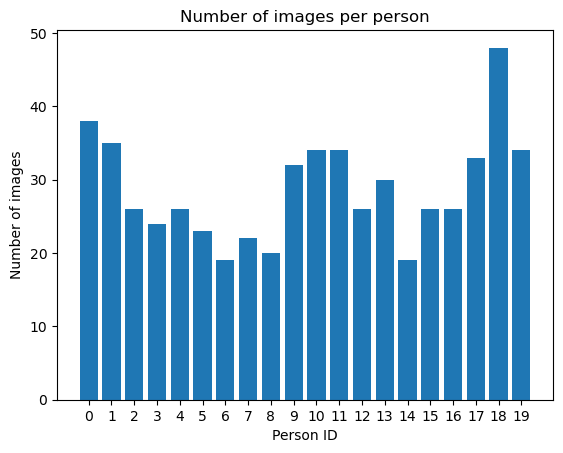

In [12]:
unique_faces, counts = np.unique(y, return_counts=True)

plt.bar(unique_faces, counts)
plt.xlabel('Person ID') 
plt.ylabel('Number of images')
plt.title('Number of images per person')
plt.xticks(ticks=unique_faces.astype(int))
plt.show()

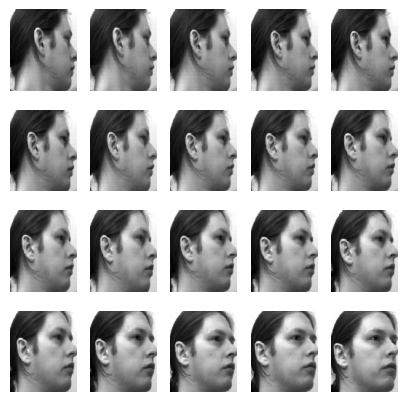

In [13]:
# Plot first person
fig, ax = plt.subplots(4, 5, figsize=(5, 5))
for i in range(20):
    ax[i//5, i%5].imshow(X[i].reshape(112, 92), cmap='gray')
    ax[i//5, i%5].axis('off')
plt.show()

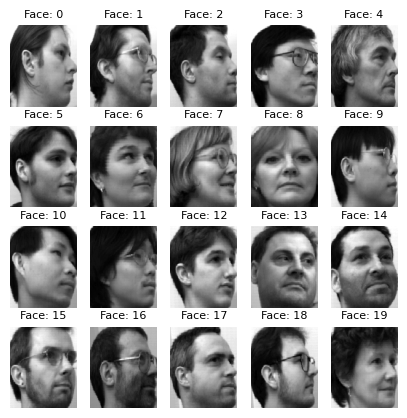

In [14]:
# Plot all unique faces
fig, ax = plt.subplots(4, 5, figsize=(5, 5))
for i in range(20):
    ax[i//5, i%5].imshow(X[y==i][10].reshape(112, 92), cmap='gray')
    ax[i//5, i%5].set_title(f'Face: {i}', fontsize=8)
    ax[i//5, i%5].axis('off')
plt.show()

In [15]:
exploration_scaler = MinMaxScaler()
exploration_pca = KernelPCA(n_components=2, random_state=123, kernel='rbf', gamma=0.001)
exploration_pipeline = Pipeline([
    ('scaler', exploration_scaler),
    ('pca', exploration_pca)
])

explored_X = exploration_pipeline.fit_transform(X)

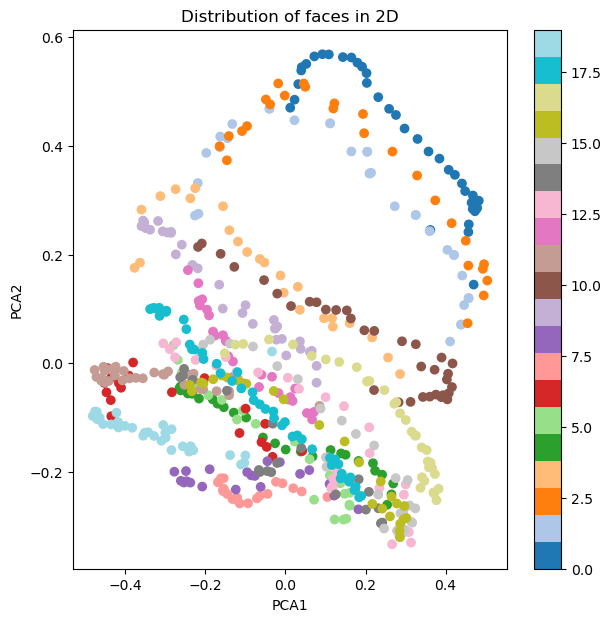

In [16]:
# Plot the distribution of faces in 2D with their labels

plt.figure(figsize=(7, 7))
plt.scatter(explored_X[:, 0], explored_X[:, 1], c=y, cmap='tab20')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Distribution of faces in 2D')
plt.colorbar()
plt.show()

In [17]:
# Dataset is imbalanced, use StratifiedShuffleSplit to split the dataset
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=123)
for train_idx, val_test_idx in sss.split(X, y):
    X_train, X_val_test = X[train_idx], X[val_test_idx]
    y_train, y_val_test = y[train_idx], y[val_test_idx]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)
for val_idx, test_idx in sss.split(X_val_test, y_val_test):
    X_val, X_test = X_val_test[val_idx], X_val_test[test_idx]
    y_val, y_test = y_val_test[val_idx], y_val_test[test_idx]

X_train.shape: (345, 10304)
X_val.shape: (115, 10304)
X_test.shape: (115, 10304)


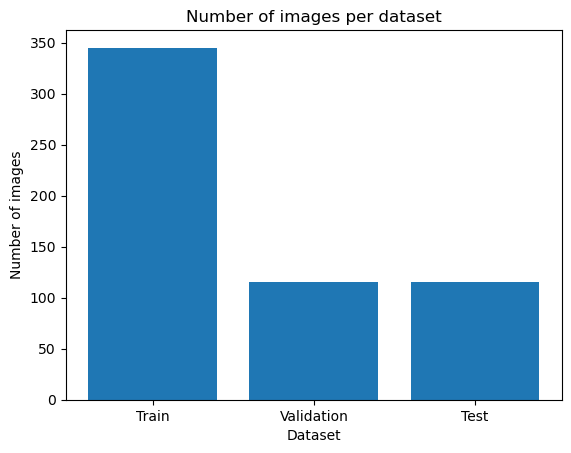

In [18]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'X_test.shape: {X_test.shape}')

x_axis = ['Train', 'Validation', 'Test']
y_axis = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]

plt.bar(x_axis, y_axis)
plt.xlabel('Dataset')
plt.ylabel('Number of images')
plt.title('Number of images per dataset')
plt.show()

In [19]:
unique_faces, train_counts = np.unique(y_train, return_counts=True)
print('Train')
for face, count in zip(unique_faces, train_counts):
    print(f'Face: {face}, Count: {count}')
    
unique_faces, val_counts = np.unique(y_val, return_counts=True)
print('Val')
for face, count in zip(unique_faces, val_counts):
    print(f'Face: {face}, Count: {count}')
    
unique_faces, test_counts = np.unique(y_test, return_counts=True)
print('Test')
for face, count in zip(unique_faces, test_counts):
    print(f'Face: {face}, Count: {count}')

Train
Face: 0, Count: 23
Face: 1, Count: 21
Face: 2, Count: 16
Face: 3, Count: 14
Face: 4, Count: 16
Face: 5, Count: 14
Face: 6, Count: 11
Face: 7, Count: 13
Face: 8, Count: 12
Face: 9, Count: 19
Face: 10, Count: 20
Face: 11, Count: 20
Face: 12, Count: 16
Face: 13, Count: 18
Face: 14, Count: 11
Face: 15, Count: 16
Face: 16, Count: 16
Face: 17, Count: 20
Face: 18, Count: 29
Face: 19, Count: 20
Val
Face: 0, Count: 7
Face: 1, Count: 7
Face: 2, Count: 5
Face: 3, Count: 5
Face: 4, Count: 5
Face: 5, Count: 5
Face: 6, Count: 4
Face: 7, Count: 4
Face: 8, Count: 4
Face: 9, Count: 7
Face: 10, Count: 7
Face: 11, Count: 7
Face: 12, Count: 5
Face: 13, Count: 6
Face: 14, Count: 4
Face: 15, Count: 5
Face: 16, Count: 5
Face: 17, Count: 7
Face: 18, Count: 9
Face: 19, Count: 7
Test
Face: 0, Count: 8
Face: 1, Count: 7
Face: 2, Count: 5
Face: 3, Count: 5
Face: 4, Count: 5
Face: 5, Count: 4
Face: 6, Count: 4
Face: 7, Count: 5
Face: 8, Count: 4
Face: 9, Count: 6
Face: 10, Count: 7
Face: 11, Count: 7
Face: 1

### Figure out some techniques to balance the dataset

In [20]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.1,
    rotation_range=10,
)

In [21]:
# Maximum number of images of any class that can be generated
max_count = max(train_counts)
max_count

29

In [22]:
reshaped_images = []
labels = []

# Loop through each person in the training set and augment images if needed
for person_idx in range(20):
    images = X_train[y_train == person_idx]  # Get all images of the current person
    
    images = images.reshape(-1, 112, 92, 1)  # Reshape the images to 4D
    
    reshaped_images.extend(images)  # Add original images to the list
    labels.extend([person_idx] * images.shape[0])  # Add labels for the current person
    
    # Number of images this person currently has
    count = images.shape[0]
    
    # Number of images to generate to match the class with the maximum number of images
    n_images = max_count - count + 1
    
    if n_images > 0:
        # Augment the images using ImageDataGenerator
        datagen.fit(images)  # Fit the generator on the person's existing images
        
        # Create a list to hold generated images
        generated_images = []
        
        # Generate new images using the flow method
        for X_batch, _ in datagen.flow(images, np.zeros(images.shape[0]), batch_size=1):
            generated_images.append(X_batch[0])
            if len(generated_images) >= n_images:  # Stop once we have enough images
                break
        
        # Extend the reshaped_images list with the new generated images
        reshaped_images.extend(generated_images)
        labels.extend([person_idx] * len(generated_images))  # Assign the corresponding labels


In [23]:
# Convert lists to numpy arrays for further use
reshaped_images = np.array(reshaped_images)
labels = np.array(labels)

print(f'reshaped_images.shape: {reshaped_images.shape}')

# Check if the set is balanced
unique_faces, counts = np.unique(labels, return_counts=True)
for face, count in zip(unique_faces, counts):
    print(f'Face: {face}, Count: {count}')


reshaped_images.shape: (600, 112, 92, 1)
Face: 0, Count: 30
Face: 1, Count: 30
Face: 2, Count: 30
Face: 3, Count: 30
Face: 4, Count: 30
Face: 5, Count: 30
Face: 6, Count: 30
Face: 7, Count: 30
Face: 8, Count: 30
Face: 9, Count: 30
Face: 10, Count: 30
Face: 11, Count: 30
Face: 12, Count: 30
Face: 13, Count: 30
Face: 14, Count: 30
Face: 15, Count: 30
Face: 16, Count: 30
Face: 17, Count: 30
Face: 18, Count: 30
Face: 19, Count: 30


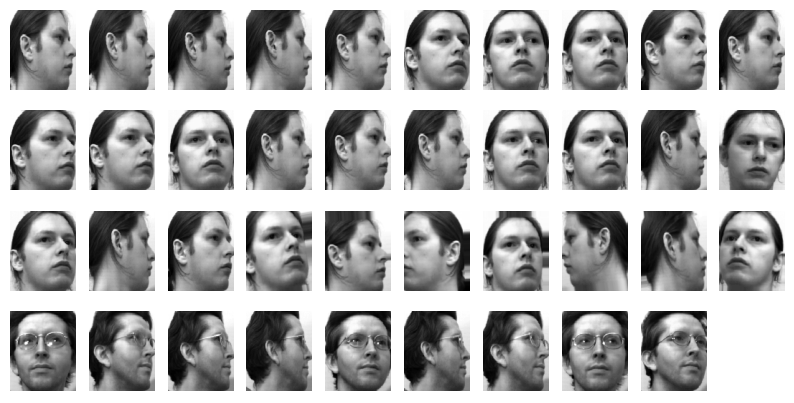

In [24]:
fig, ax = plt.subplots(4, 10, figsize=(10, 5))
for i in range(39):
    ax[i//10, i%10].imshow(reshaped_images[i].reshape(112, 92), cmap='gray')
    ax[i//10, i%10].axis('off')
ax[3, 9].axis('off')
plt.show()

In [ ]:
# Preprocess the images
X_train_preprocessed = preprocess_input(reshaped_images)

In [28]:
X_train_preprocessed.shape

(600, 112, 92, 1)

In [35]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.models import Model
import tensorflow as tf

input_layer = Input(shape=(112, 92, 1))  # Input layer for the grayscale images

# Convert the grayscale images to 3 channels
rbg_layer = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_layer)

In [36]:
# Load the MobileNetV2 model to do feature extraction
base_model = MobileNetV2(
    include_top=False,  # Do not include the top layer
    weights='imagenet',  # Use the pre-trained weights on ImageNet
    input_shape=(112, 92, 3)  # Input shape of the images
)
output_layer = base_model(rbg_layer)

In [37]:
model = Model(inputs=input_layer, outputs=output_layer)

In [39]:
# Extract features from the images

features = model.predict(X_train_preprocessed)

print(f'features.shape: {features.shape}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
features.shape: (600, 4, 3, 1280)


In [42]:
feature_flatten = features.reshape(features.shape[0], -1)

In [44]:
feature_df = pd.DataFrame(feature_flatten, columns=[f'feature_{i}' for i in range(feature_flatten.shape[1])])

In [45]:
feature_df.to_csv('preprocessing_data.csv', index=False)